In [77]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

import json
import requests

import wrangle
import prepare as prep

from env import github_token, github_username

from wordcloud import WordCloud

from sklearn.model_selection import train_test_split

import re
import unicodedata
import nltk

plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-darkgrid')

## Acquire and Prep

In [53]:
df = pd.read_json("data.json")
df.head()

,repo,language,readme_contents
0,mcastrolab/Brazil-Covid19-e0-change,R,# Reduction in life expectancy in Brazil after...
1,jschoeley/de0anim,R,# Animated annual changes in life-expectancy\n...
2,sychi77/Thoracic_Surgery_Patient_Survival,Jupyter Notebook,# Thoracic Surgery for Lung Cancer Data Set\n ...
3,ashtad63/HackerRank-Data-Scientist-Hiring-Test,Jupyter Notebook,# HackerRank Data Scientist Hiring Test: Predi...
4,OxfordDemSci/ex2020,R,"<p align=""center"">\n <img src=""https://github..."


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166 entries, 0 to 165
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             166 non-null    object
 1   language         157 non-null    object
 2   readme_contents  166 non-null    object
dtypes: object(3)
memory usage: 4.0+ KB


In [65]:
df[df['readme_contents'].str.len() == 0].shape[0]

26

In [66]:
df_copy = df.copy()

In [52]:
df = prep.prep_data(df)
df.head()

,repo,language,original,clean,more_clean,char_count,word_count,unique_word_count
0,mcastrolab/Brazil-Covid19-e0-change,R,# Reduction in life expectancy in Brazil after...,reduction life expectancy brazil covid 19 prov...,reduction life expectancy brazil covid 19 prov...,3340,522,267
1,jschoeley/de0anim,R,# Animated annual changes in life-expectancy\n...,animated annual changes life expectancy illust...,animated annual change life expectancy illustr...,178,24,22
2,sychi77/Thoracic_Surgery_Patient_Survival,Python,# Thoracic Surgery for Lung Cancer Data Set\n ...,thoracic surgery lung cancer data set uci mach...,thoracic surgery lung cancer data set uci mach...,2191,307,171
3,ashtad63/HackerRank-Data-Scientist-Hiring-Test,Python,# HackerRank Data Scientist Hiring Test: Predi...,hackerrank data scientist hiring test predict ...,hackerrank data scientist hiring test predict ...,1014,136,86
4,OxfordDemSci/ex2020,R,"<p align=""center"">\n <img src=""https://github...",p align center img src https github com oxford...,p align center img src http github com oxfordd...,2432,363,220


In [6]:
df.language.value_counts()

other     65
Python    48
R         31
HTML      22
Name: language, dtype: int64

In [7]:
df_all_languages = prep.prep_data(df_copy, keep_top_languages=False)

In [8]:
df_all_languages.language.value_counts()

Python         67
R              31
HTML           22
JavaScript     16
Stata           5
Java            3
Dart            3
Scala           2
Swift           2
MATLAB          1
Shell           1
TypeScript      1
Ruby            1
Objective-C     1
Scheme          1
Name: language, dtype: int64

## Split Data

In [9]:
def split_data(df):
    train_validate, test = train_test_split(df, test_size=.2, random_state=123)
    train, validate = train_test_split(train_validate, test_size=.3, random_state=123)
    return train, validate, test

In [10]:
train, validate, test = split_data(df)
train.shape, validate.shape, test.shape

((92, 8), (40, 8), (34, 8))

In [11]:
train_languages, validate_languages, test_languages = split_data(df_all_languages)
train_languages.shape

(92, 8)

## Explore 
#### Pre-Processing

In [12]:
def show_counts_and_ratios(df, column):
    """
    Takes in a dataframe and a string of a single column
    Returns a dataframe with absolute value counts and percentage value counts
    """
    labels = pd.concat([df[column].value_counts(),
                    df[column].value_counts(normalize=True)], axis=1)
    labels.columns = ['n', 'percent']
    labels
    return labels

show_counts_and_ratios(train, "language")

,n,percent
other,35,0.380435
Python,28,0.304348
HTML,15,0.163043
R,14,0.152174


In [13]:
def clean(text):
    'A simple function to cleanup text data'
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english')
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]


In [14]:
## Create lists of words for each language category
other = clean(' '.join(train[train.language == 'other'].original))
python = clean(' '.join(train[train.language == 'Python'].original))
r = clean(' '.join(train[train.language == 'R'].original))
html = clean(' '.join(train[train.language == 'HTML'].original))
all_words = clean(' '.join(train.original))

In [42]:
## Transform lists into series
other_freq = pd.Series(other).value_counts()
python_freq = pd.Series(python).value_counts()
r_freq = pd.Series(r).value_counts()
html_freq = pd.Series(html).value_counts()
all_freq = pd.Series(all_words).value_counts()

other_freq.head(10)

feature       100
life           71
expectancy     65
data           59
file           52
set            37
1              36
using          34
float          33
used           30
dtype: int64

In [43]:
python_freq.head(10)

life          87
expectancy    80
data          72
country       58
factor        44
model         35
health        31
img           28
dataset       27
regression    25
dtype: int64

In [45]:
r_freq.head(10)

life          33
expectancy    31
data          27
health        19
year          16
2020          14
country       12
covid19       11
code          11
death         10
dtype: int64

In [46]:
html_freq.head(10)

life          29
expectancy    27
file          25
data          16
rmd           14
html          12
median        11
survival      11
death         11
project       11
dtype: int64

In [16]:
#Create a word_counts data frame we can work with

word_counts = (pd.concat([all_freq, other_freq, python_freq, r_freq, html_freq], axis=1, sort=True)
                .set_axis(['all', 'other', 'python', 'r', 'html'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

word_counts.head()

,all,other,python,r,html
0,15,1,13,1,0
000,1,0,1,0,0
00074,1,0,1,0,0
00078,1,0,1,0,0
00123,1,0,1,0,0


### Answer questions about word frequency:

**What are the most frequently occuring words?**

In [17]:
word_counts.sort_values(by='all', ascending=False).head(20)

,all,other,python,r,html
life,220,71,87,33,29
expectancy,203,65,80,31,27
data,174,59,72,27,16
feature,123,100,23,0,0
country,109,29,58,12,10
file,89,52,6,6,25
1,63,36,18,6,3
health,62,9,31,19,3
model,61,18,35,6,2
year,58,11,23,16,8


Text(0.5, 1.0, 'Word Count for top 20 Most Frequent Overall Words')

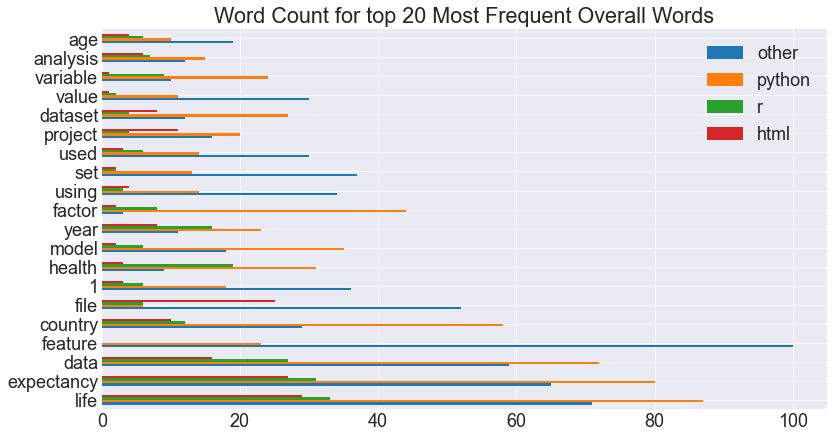

In [102]:
plt.rc('font', size=18)
word_counts.sort_values('all', ascending=False).head(20)[['other', 'python', 'r', 'html']].plot.barh()
plt.title('Word Count for top 20 Most Frequent Overall Words')

Text(0.5, 1.0, '% of Language Frequency for the most common 20 words')

<Figure size 1152x648 with 0 Axes>

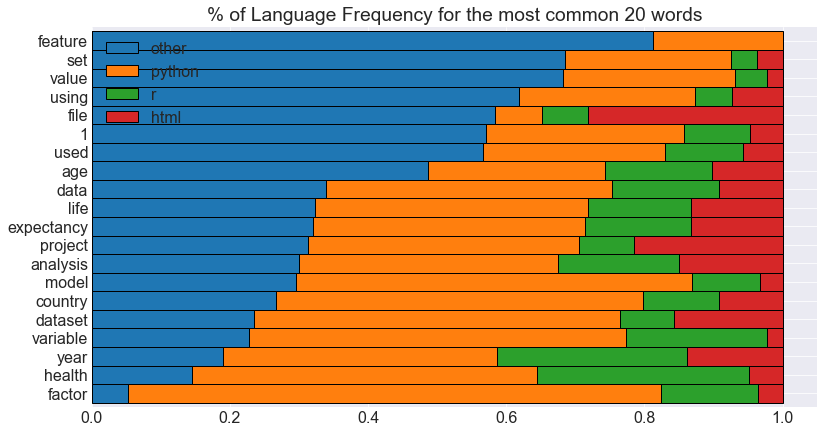

In [86]:
plt.figure(figsize=(16, 9))
plt.rc('font', size=16)

(word_counts.sort_values('all', ascending=False)
 .head(20)
 .apply(lambda row: row/row['all'], axis = 1)
 .drop(columns = 'all')
 .sort_values(by = 'other')
 .plot.barh(stacked = True, width = 1, ec = 'k')
)
plt.title('% of Language Frequency for the most common 20 words')

Text(0.5, 1.0, '% of Language Frequency for the most common 5 words')

<Figure size 1152x648 with 0 Axes>

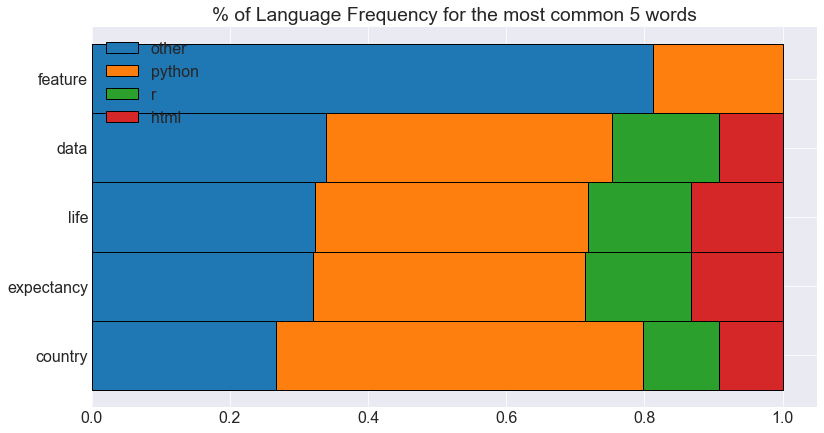

In [108]:
plt.figure(figsize=(16, 9))
plt.rc('font', size=16)

(word_counts.sort_values('all', ascending=False)
 .head(5)
 .apply(lambda row: row/row['all'], axis = 1)
 .drop(columns = 'all')
 .sort_values(by = 'other')
 .plot.barh(stacked = True, width = 1, ec = 'k')
)
plt.title('% of Language Frequency for the most common 5 words')

**Are there any words that uniquely identify one of the coding languages?**

In [18]:
pd.concat([word_counts[word_counts.other == 0].sort_values(by='other').tail(6),
           word_counts[word_counts.python == 0].sort_values(by='python').tail(6),
           word_counts[word_counts.r == 0].sort_values(by='r').tail(6),
           word_counts[word_counts.html == 0].sort_values(by='html').tail(6)])

,all,other,python,r,html
e0,4,0,0,4,0
dyspnoea,1,0,1,0,0
dynamic_gdp_graph,1,0,0,0,1
dying,2,0,1,1,0
eastward,1,0,1,0,0
zubrod,1,0,1,0,0
excluded,1,1,0,0,0
excess,1,0,0,1,0
excel,2,1,0,1,0
examining,1,0,0,0,1


Text(0.5, 1.0, 'Proportion of Language Word Frequency for the 20 most common words')

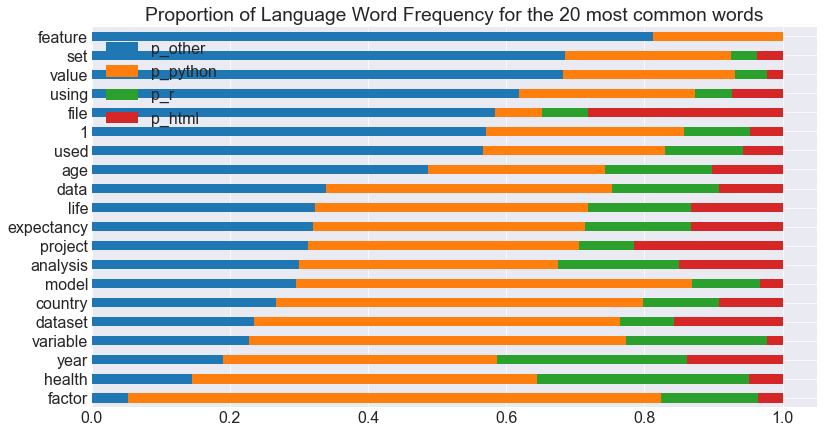

In [85]:
# figure out the percentage of spam vs ham
(word_counts
 .assign(p_other=word_counts.other / word_counts['all'],
         p_python=word_counts.python / word_counts['all'],
         p_r=word_counts.r / word_counts['all'],
         p_html=word_counts.html / word_counts['all'])
 .sort_values(by='all')
 [['p_other', 'p_python', 'p_r', 'p_html']]
 .tail(20)
 .sort_values('p_other')
 .plot.barh(stacked=True))

plt.title('Proportion of Language Word Frequency for the 20 most common words')


### Create and Visualize Bigrams

In [20]:
# Top 20 other
top_20_other_bigrams = (pd.Series(nltk.ngrams(other, 2))
                      .value_counts()
                      .head(20))

top_20_other_bigrams.head()

(life, expectancy)    64
(sex, age)            15
(expectancy, sex)     14
(age, income)         12
(survival, rate)      12
dtype: int64

In [21]:
# Top 20 python 
top_20_python_bigrams = (pd.Series(nltk.ngrams(python, 2))
                      .value_counts()
                      .head(20))

top_20_python_bigrams.head()

(life, expectancy)     79
(machine, learning)    13
(1, f)                 11
(f, 0)                 11
(aligncenter, img)      9
dtype: int64

In [22]:
# Top 20 r
top_20_r_bigrams = (pd.Series(nltk.ngrams(r, 2))
                      .value_counts()
                      .head(20))

top_20_r_bigrams.head()

(life, expectancy)           30
(per, 1000)                   5
(change, life)                5
(global, health)              5
(1000, populationobjectn)     5
dtype: int64

In [23]:
# Top 20 html
top_20_html_bigrams = (pd.Series(nltk.ngrams(html, 2))
                      .value_counts()
                      .head(20))

top_20_html_bigrams.head()

(life, expectancy)    27
(rmd, file)           14
(mean, median)        10
(median, survival)     8
(html, file)           7
dtype: int64

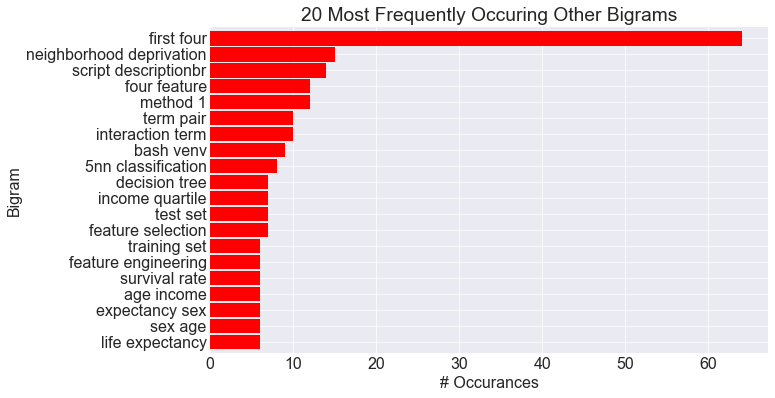

In [99]:
## Plot Top 20 Other

top_20_other_bigrams.sort_values().plot.barh(color='red', width=.9, figsize=(10, 6))

plt.title('20 Most Frequently Occuring Other Bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_other_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)


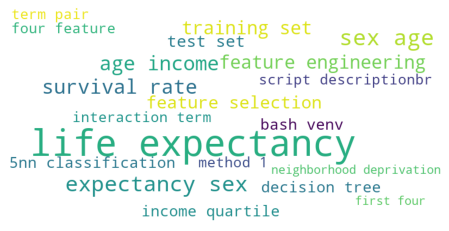

In [25]:
## Create a wordcloud 
data = {k[0] + ' ' + k[1]: v for k, v in top_20_other_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

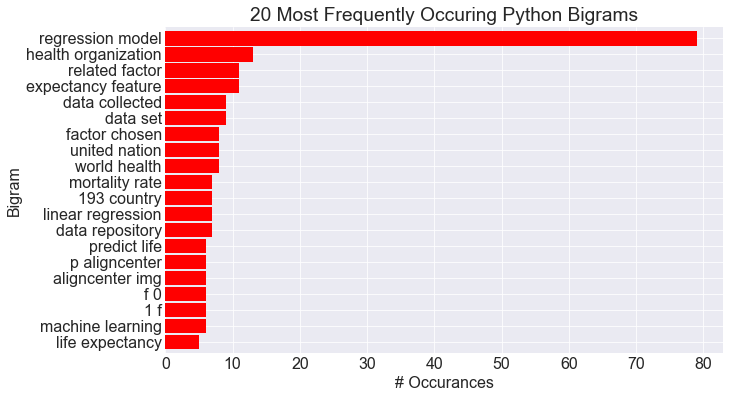

In [95]:
## Plot Top 20 python

top_20_python_bigrams.sort_values().plot.barh(color='red', width=.9, figsize=(10, 6))

plt.title('20 Most Frequently Occuring Python Bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_python_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)


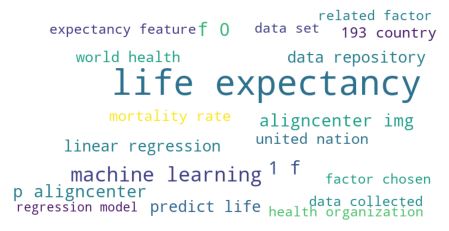

In [27]:
## Create a wordcloud 
data = {k[0] + ' ' + k[1]: v for k, v in top_20_python_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

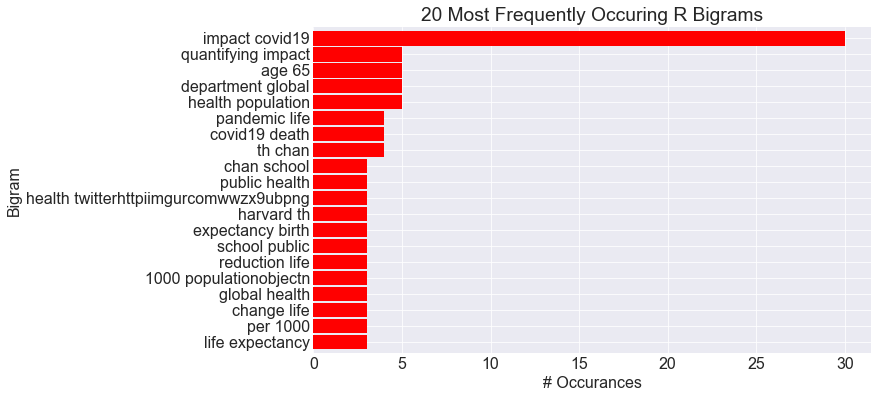

In [96]:
## Plot Top 20 r

top_20_r_bigrams.sort_values().plot.barh(color='red', width=.9, figsize=(10, 6))

plt.title('20 Most Frequently Occuring R Bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_r_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

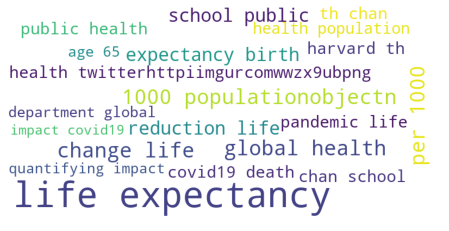

In [29]:
## Create a wordcloud 
data = {k[0] + ' ' + k[1]: v for k, v in top_20_r_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

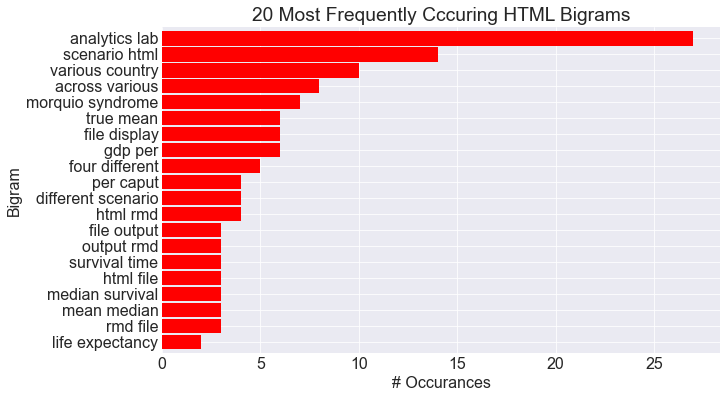

In [97]:
## Plot Top 20 html

top_20_html_bigrams.sort_values().plot.barh(color='red', width=.9, figsize=(10, 6))

plt.title('20 Most Frequently Cccuring HTML Bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_html_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

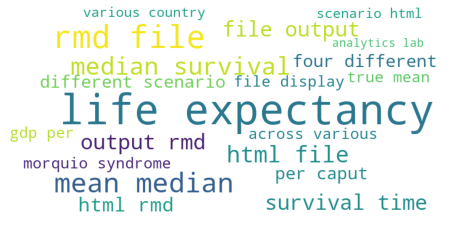

In [31]:
## Create a wordcloud 
data = {k[0] + ' ' + k[1]: v for k, v in top_20_html_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

#### Add Other Features to Explore

In [32]:
#Create a function to get the character count of each doc
def get_char_count(string):
    """
    This function will take in a string and return the number of characters in it.
    """
    
    return len(string)

In [33]:
def get_word_count(string):
    """
    This function will take in a string and return the number of words in that string.
    This function will include repeat words.
    """
    
    #Create a list of words separated by a space
    words = string.split()
    
    return len(words)

In [34]:
def get_unique_words(string):
    """
    This function will take in a string and return the number of unique words in that string.
    """
    
    words = string.split()
    words = set(words)
    
    return len(words)

In [35]:
def get_sentence_count(string):
    """
    This function will take in a string and return the number of sentences in that string.
    """
    
    sentences = nltk.sent_tokenize(string)
    
    return len(sentences)

In [36]:
train['sentence_count'] = train.original.apply(get_unique_words)
train.head()

,repo,language,original,clean,more_clean,char_count,word_count,unique_word_count,sentence_count
77,AntoineGuiot/OWKIN_PROJECT,Python,,,,0,0,0,0
92,sejaldua/life-expectancy,other,# life-expectancy\nCreating a simple app to vi...,life expectancy creating simple app visualize ...,life expectancy creating simple app visualize ...,104,13,11,16
94,NEXTSLIM/Life-Expectancy,Python,# Life-Expectancy(DATA ANALYSIS)\nCan we corre...,life expectancy data analysis correctly predic...,life expectancy data analysis correctly predic...,1039,141,89,134
16,aleynahukmet/life-expectancy-prediction,Python,"# Life-Expectancy-Prediction\n<p align=""center...",life expectancy prediction p align center img ...,life expectancy prediction p align center img ...,3653,534,272,369
0,mcastrolab/Brazil-Covid19-e0-change,R,# Reduction in life expectancy in Brazil after...,reduction life expectancy brazil covid 19 prov...,reduction life expectancy brazil covid 19 prov...,3340,522,267,314


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166 entries, 0 to 165
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   repo               166 non-null    object
 1   language           166 non-null    object
 2   original           166 non-null    object
 3   clean              166 non-null    object
 4   more_clean         166 non-null    object
 5   char_count         166 non-null    int64 
 6   word_count         166 non-null    int64 
 7   unique_word_count  166 non-null    int64 
dtypes: int64(3), object(5)
memory usage: 10.5+ KB


In [71]:
train[train['char_count'] <=0]

,repo,language,original,clean,more_clean,char_count,word_count,unique_word_count,sentence_count
77,AntoineGuiot/OWKIN_PROJECT,Python,,,,0,0,0,0
11,yc244/Stata-code_BMC-Medince2019_Chudasama,other,,,,0,0,0,0
80,MingXXI/LifeExpectancyLinearModel,other,,,,0,0,0,0
69,pjmerica/415-final-Project,other,,,,0,0,0,0
27,emmanuelAkpe/LifeExpectancy,Python,,,,0,0,0,0
66,t-redactyl/life-expectancy-analysis,Python,,,,0,0,0,0
58,wrigleyfield/hypotheticalwhite2020mortality,other,,,,0,0,0,0
158,nsudharsanan/epi_rural_urban_mortality_indonesia,R,,,,0,0,0,0
106,JeremyMiranda/Life-Expectancy,R,,,,0,0,0,0
97,Abhinav1092/Life-expectancy,Python,,,,0,0,0,0


<AxesSubplot:xlabel='language', ylabel='word_count'>

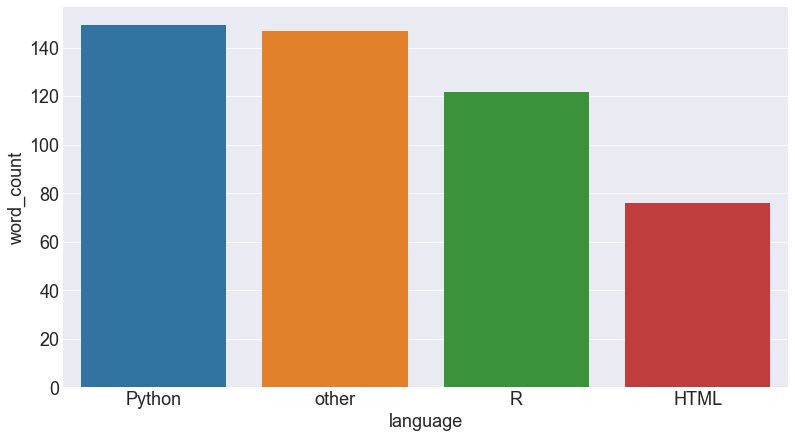

In [106]:
sns.barplot(data=train, y='word_count', x='language', ci=None)

<AxesSubplot:xlabel='language', ylabel='char_count'>

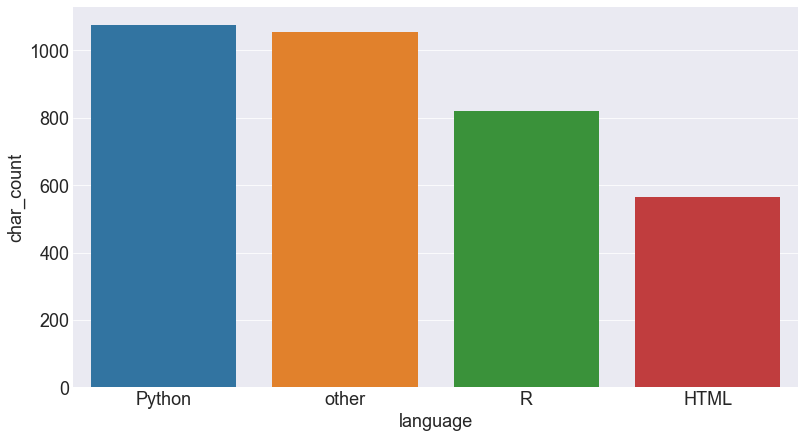

In [105]:
sns.barplot(data=train, y='char_count', x='language', ci=None)

<AxesSubplot:xlabel='language', ylabel='sentence_count'>

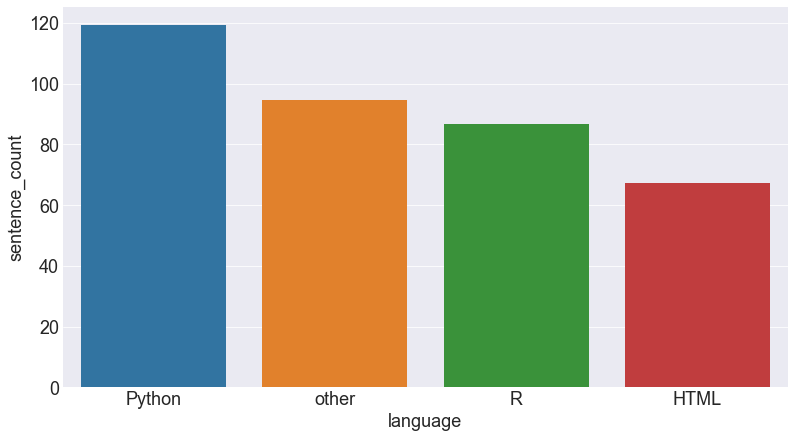

In [107]:
sns.barplot(data=train, y='sentence_count', x='language', ci=None)